In [1]:
import sqlite3
import math
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt

from itertools import cycle, islice
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Data

In [2]:
database = 'database.sqlite'

In [3]:
data = sqlite3.connect(database)
tables = pd.read_sql("SELECT * FROM sqlite_master WHERE type='table'", data)

In [4]:
tables.name

0      sqlite_sequence
1    Player_Attributes
2               Player
3                Match
4               League
5              Country
6                 Team
7      Team_Attributes
Name: name, dtype: object

## Countries and Leagues

In [5]:
leagues = pd.read_sql("SELECT * FROM League JOIN Country on Country.id == League.id", data)

In [6]:
leagues.head()

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy


## Teams

In [7]:
teams = pd.read_sql("SELECT * FROM Team", data)

In [8]:
print('number of teams:', len(teams["team_long_name"].unique()))

number of teams: 296


In [9]:
teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


## Players

In [10]:
players = pd.read_sql("SELECT * FROM Player", data)

In [11]:
players.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


## Player Attributes

In [12]:
player_attributes = pd.read_sql("SELECT * FROM Player_Attributes", data)

In [13]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


## Match

In [14]:
matches = pd.read_sql("SELECT * FROM Match", data)

In [15]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


# Data Visualization

## Leagues Proportion

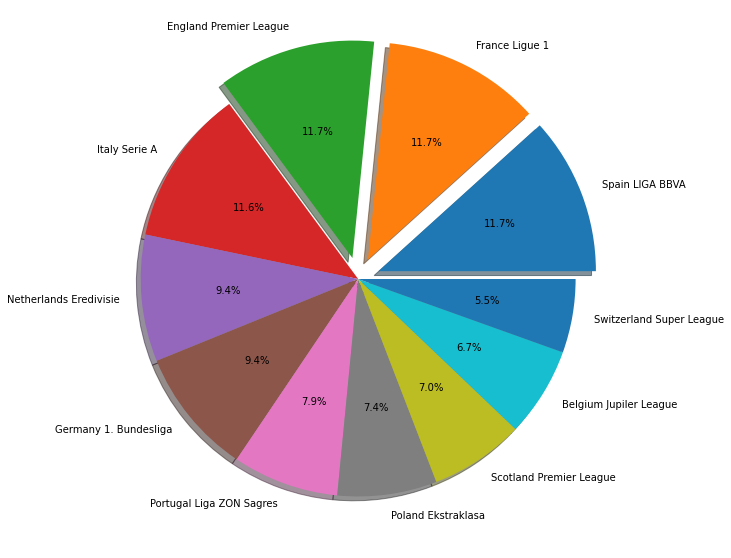

In [16]:
#count the number of each league
pie_match_count = matches['league_id'].value_counts()

list_label = ["Spain LIGA BBVA","France Ligue 1","England Premier League",
            "Italy Serie A","Netherlands Eredivisie","Germany 1. Bundesliga",
            "Portugal Liga ZON Sagres","Poland Ekstraklasa",
            "Scotland Premier League","Belgium Jupiler League",
            "Switzerland Super League"]

fig1,ax1 = plt.subplots(nrows=1, ncols=1)
fig1.set_size_inches(w=15, h=10)

#emphasize on top 3 leauges
pie_plot = plt.pie(pie_match_count,labels=list_label,shadow=True, explode=(0.1,0.1,0.1,0,0,0,0,0,0,0,0),autopct="%1.1F%%")

## Players attributes correlation

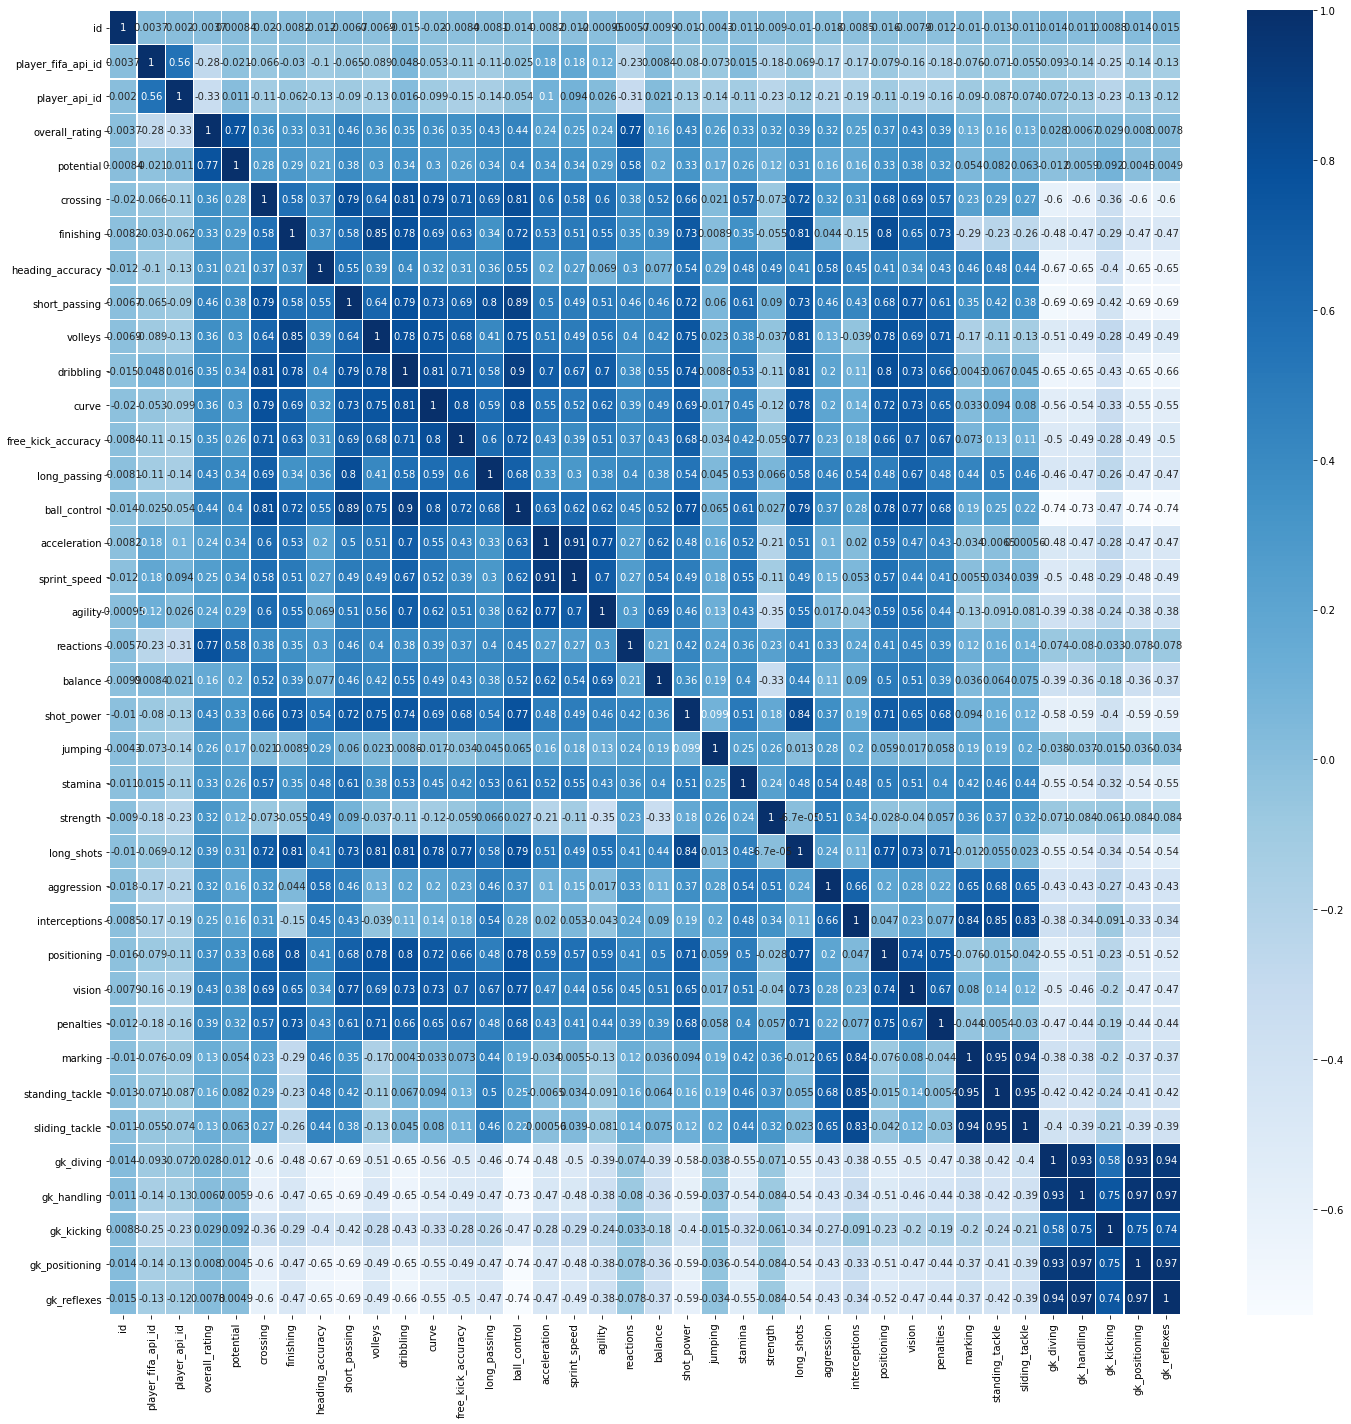

In [17]:
player_attributes_wo_na = player_attributes.dropna()
player_attributes_corr = player_attributes_wo_na.corr()

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=24, h=24)
sns.heatmap(player_attributes_corr, annot = True, linewidths=0.5, ax=ax, cmap="Blues")

## Sorted Correlations

<BarContainer object of 35 artists>

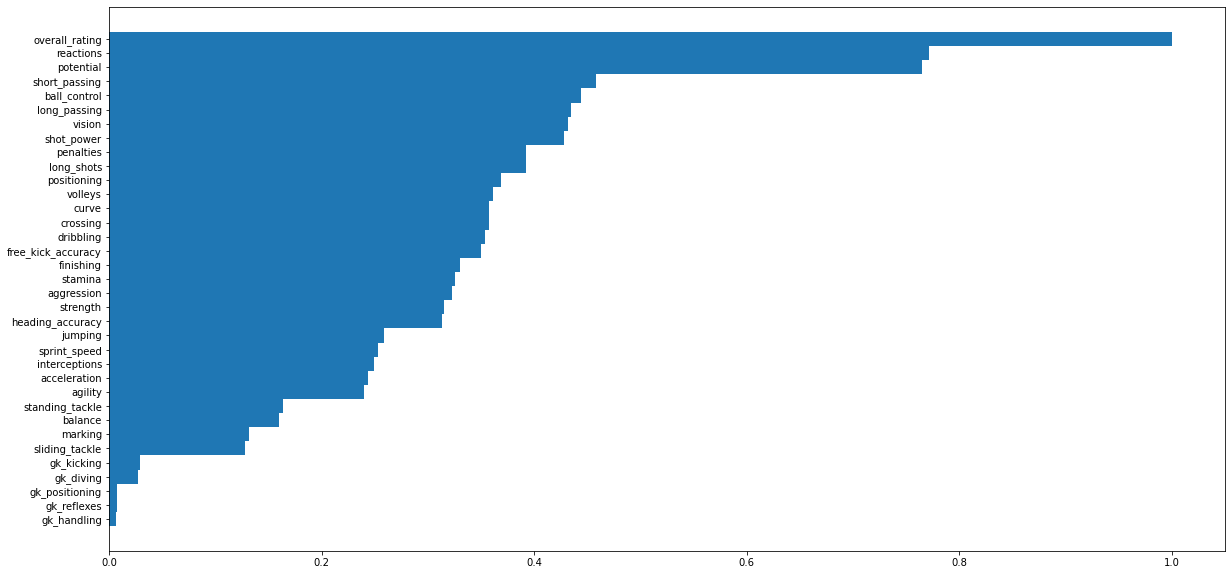

In [18]:
df_overall_rating_corr = player_attributes_corr['overall_rating']

df_single_corr = pd.DataFrame(df_overall_rating_corr)
df_single_corr = df_single_corr.sort_values(by=['overall_rating'],ascending=True) 

#drop first three rows since we only care about positive correlation
index_headers = list(df_single_corr[3:].index) 
plt.figure(figsize=(20, 10))
plt.barh(y=index_headers, width=df_single_corr.overall_rating[3:], height=1, linewidth=0.5)

## Right Foot v.s. Left Foot / Potential Distribution

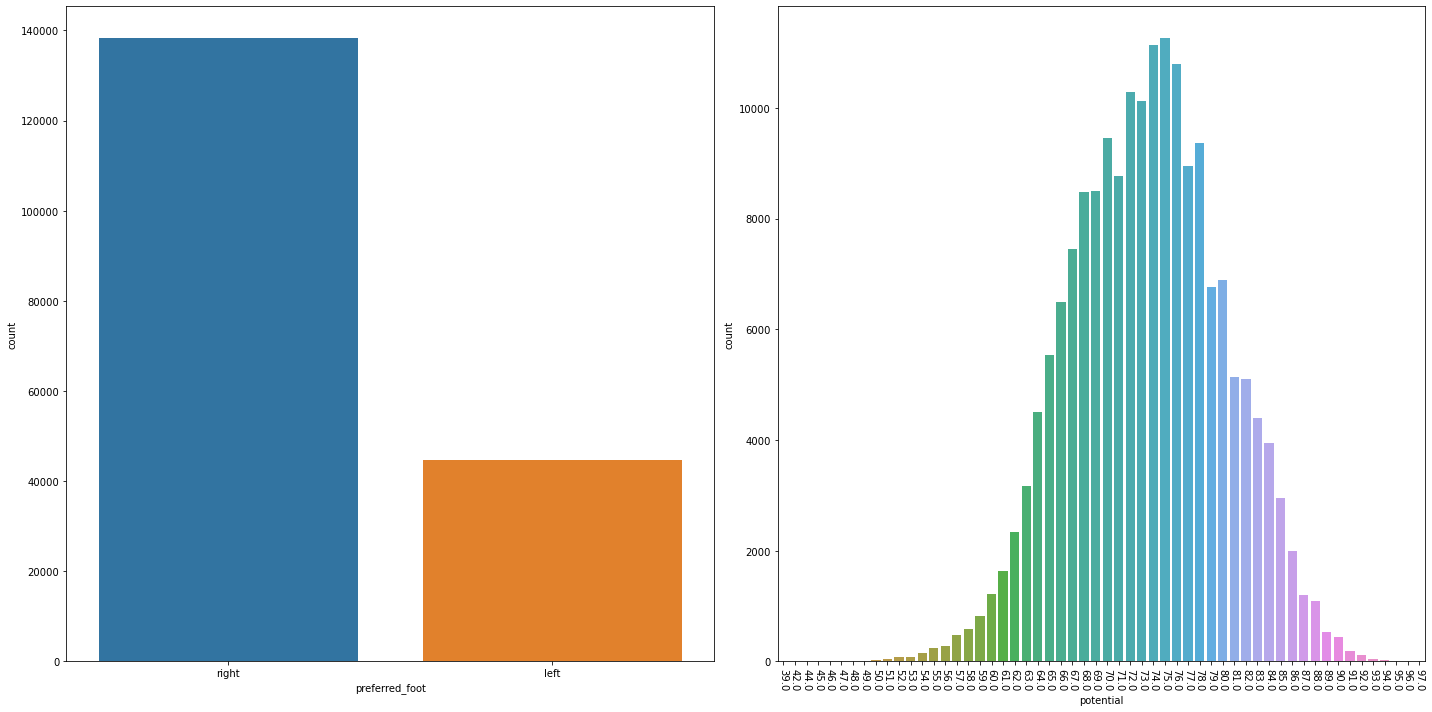

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(20,10)

sns.countplot(x = player_attributes['preferred_foot'], ax=ax[0])
sns.countplot(x = player_attributes['potential'], ax=ax[1])

pl.xticks(rotation=270)
fig.tight_layout()

## Home Advantage

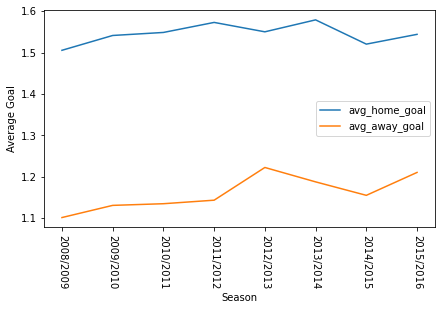

In [20]:
df_goal = matches[['season','home_team_goal','away_team_goal']]
D = {}

for i in range(len(df_goal)):
    key_season = df_goal.iloc[i].season
    if key_season not in D:
        D[key_season] = [1, df_goal.iloc[i].home_team_goal, df_goal.iloc[i].away_team_goal]
    else:
        D[key_season][0] += 1
        D[key_season][1] += df_goal.iloc[i].home_team_goal
        D[key_season][2] += df_goal.iloc[i].away_team_goal
        
for key in D:
    D[key][1] /= D[key][0]
    D[key][2] /= D[key][0]
    
df_goal_info = pd.DataFrame(D)
column_headers = list(df_goal_info.columns.values)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=7, h=4)
plt.plot(column_headers, df_goal_info.iloc[1], label='avg_home_goal')
plt.plot(column_headers, df_goal_info.iloc[2], label='avg_away_goal')
pl.xticks(rotation=270)
plt.xlabel("Season")
plt.ylabel("Average Goal")
plt.legend()

## Radar Chart on Top N Players

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


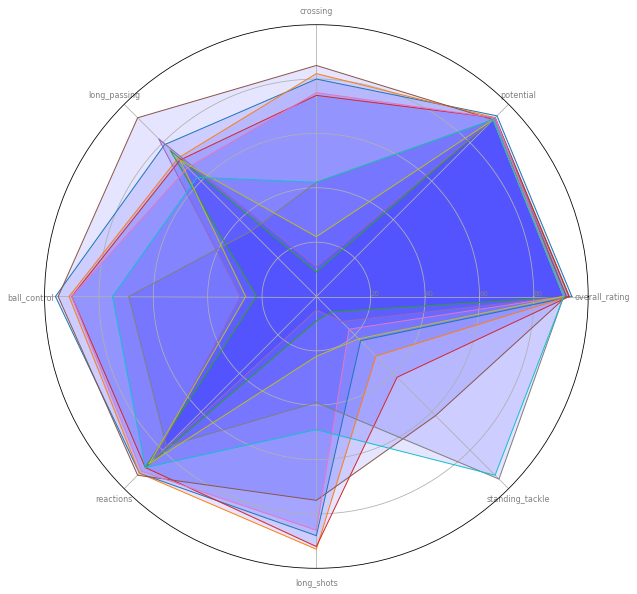

In [21]:
num_of_top_players = 10

df_overall_rating = player_attributes[['id', 'player_api_id', 'overall_rating']]
df_record = df_overall_rating.sort_values(by='overall_rating', ascending=False)
df_record.drop_duplicates('player_api_id', 'first', inplace=True)
top_n_records = df_record[:num_of_top_players]
index_headers = list(top_n_records.index)

df_name = players[['id','player_api_id','player_name']]
top_n_players = pd.DataFrame()
for i in range(len(top_n_records)):
    x = top_n_records.player_api_id.iat[i]
    top_n_players.loc[i, 'Name'] = df_name[players.player_api_id == x].player_name.iat[0]

# choose interested features
radar_info = pd.DataFrame()
radar_info = player_attributes.iloc[index_headers,:]
df = radar_info[['overall_rating', 'potential', 'crossing', 'long_passing',
                 'ball_control', 'reactions', 'long_shots', 'standing_tackle']]

categories = list(df)[:]
N = len(categories)
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=10, h=10)

# plot
for i in range(num_of_top_players):
    values = df.iloc[i].values.flatten().tolist()
    values += values[:1]
    
    # the angle of each axis in the plot
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80], ["20","40","60","80"], color="grey", size=7)
    plt.ylim(0,100) 
    
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid') 
    
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

# K-Means Clustering on Player Attributes

In [22]:
# select features used by k-means model
select_features = ['overall_rating','potential', 'crossing', 'finishing', 'heading_accuracy',
                  'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
                  'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
                  'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
                  'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
                  'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
                  'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning','gk_reflexes']

player_attributes = player_attributes.dropna()
df_select = player_attributes[select_features]

In [23]:
# Perform scaling on the dataframe containing the selected features
data = scale(df_select)

# Train a model
model = KMeans(init='k-means++', n_clusters=3, n_init=20).fit(data)

In [24]:
print(35*'*')
print("Count of players in each cluster")
print(35*'*')

pd.value_counts(model.labels_, sort=False)

***********************************
Count of players in each cluster
***********************************


0    68529
1    14602
2    97223
dtype: int64

In [25]:
# define functions for finding class representatives and plotting the parallel plots
def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    
    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data, rg):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(18,6)).gca().axes.set_ylim(rg)
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [26]:
# display class representatives
Pan = pd_centers(featuresUsed=select_features, centers=model.cluster_centers_)
Pan['prediction'] = Pan['prediction'].replace([0,1,2], ['class1','class2','class3'])
Pan.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,prediction
0,-0.555110,-0.480979,-0.329776,-0.600080,0.260004,-0.212312,-0.574051,-0.447543,-0.487834,-0.451853,...,-0.455192,0.575353,0.528883,0.541673,-0.291609,-0.276490,-0.204649,-0.272963,-0.274401,class1
1,-0.064800,-0.145709,-2.111092,-1.671034,-2.312899,-2.430493,-1.763729,-2.278102,-1.938106,-1.738074,...,-1.649962,-1.334653,-1.461961,-1.389771,3.274564,3.180168,2.063827,3.180513,3.205630,class2
2,0.401383,0.361238,0.549858,0.674447,0.164071,0.514973,0.670010,0.658039,0.635381,0.579941,...,0.569058,-0.205398,-0.153484,-0.173354,-0.286263,-0.282747,-0.165703,-0.285287,-0.288046,class3


In [27]:
# replace attribute names with numbers to avoid overlappings in parallel plot x-axis 
newColNames = list(range(len(select_features)))
res = {list(Pan.columns)[i]: newColNames[i] for i in range(len(list(Pan.columns)[:-1]))}
Pan.rename(columns=res, inplace=True)
Pan.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,prediction
0,-0.555110,-0.480979,-0.329776,-0.600080,0.260004,-0.212312,-0.574051,-0.447543,-0.487834,-0.451853,...,-0.455192,0.575353,0.528883,0.541673,-0.291609,-0.276490,-0.204649,-0.272963,-0.274401,class1
1,-0.064800,-0.145709,-2.111092,-1.671034,-2.312899,-2.430493,-1.763729,-2.278102,-1.938106,-1.738074,...,-1.649962,-1.334653,-1.461961,-1.389771,3.274564,3.180168,2.063827,3.180513,3.205630,class2
2,0.401383,0.361238,0.549858,0.674447,0.164071,0.514973,0.670010,0.658039,0.635381,0.579941,...,0.569058,-0.205398,-0.153484,-0.173354,-0.286263,-0.282747,-0.165703,-0.285287,-0.288046,class3


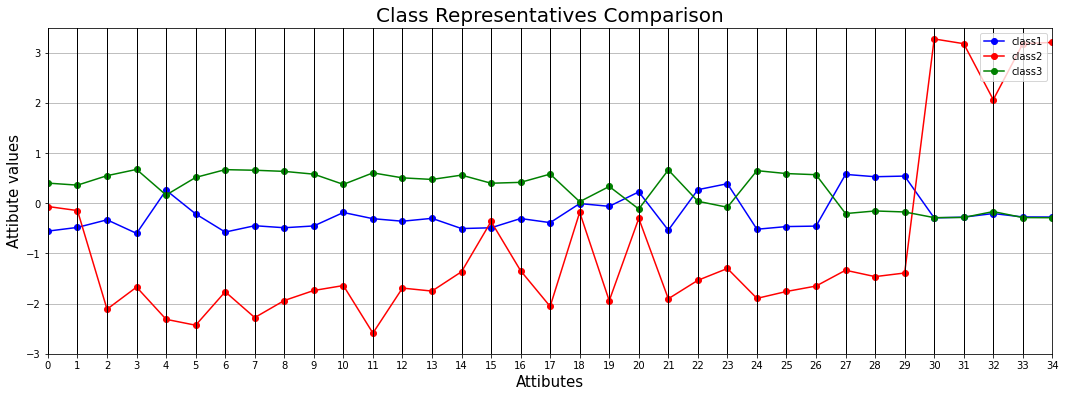

In [28]:
# parallel plots for three class representatives
parallel_plot(Pan, [-3,+3.5])
plt.xlabel("Attibutes", fontsize=15)
plt.ylabel("Attibute values", fontsize=15)
plt.title('Class Representatives Comparison', fontsize=20)
plt.show()

# PCA Analysis

In [29]:
# used to find the feature names corresponding to the numbers on x-axis above
# featureNum contains features that have relatively larger variances for three classes
feature_id = [0,2,3,5,6,7,8,9,10,11,12,13,14,16,17,21,24,25,26,27,28,29]
select_PCA_features = []

for f_name, f_id in res.items():
    if f_id in feature_id:
        select_PCA_features.append(f_name)
        
x = player_attributes.loc[:, select_PCA_features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [30]:
# perform 3 component PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head(3)

,principal component 1,principal component 2,principal component 3
0,1.683055,-1.754017,-0.118772
1,1.683055,-1.754017,-0.118772
2,1.785925,-1.629021,-0.246586


<IPython.core.display.Javascript object>


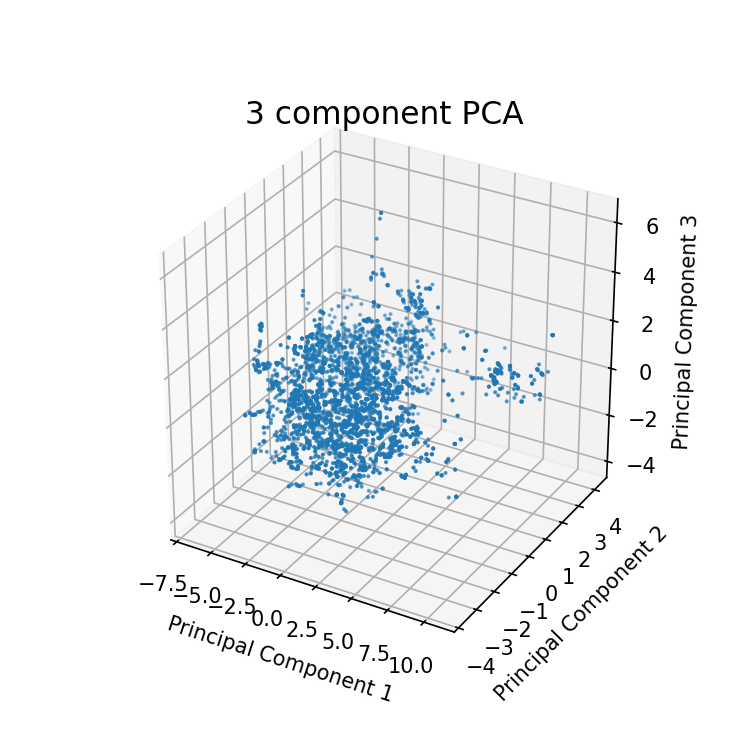

In [32]:
%matplotlib notebook

# plot players dataset projection on three principal components
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1 ,projection='3d') 
ax.set_title('3 component PCA', fontsize=15)

# plot first k players' info along principal components
k = 4000
ax.scatter(principalDf.loc[:k, 'principal component 1']
               , principalDf.loc[:k, 'principal component 2']
               , principalDf.loc[:k, 'principal component 3']
               , s = 1)

ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_zlabel('Principal Component 3', fontsize=10)
plt.show()

# K-Means on PCA

In [33]:
# perform k-means on the above pca result
# Perform scaling on the dataframe containing the features
data_pca = scale(principalDf)

# Train a model
model_kmeans_pca = KMeans(init='k-means++', n_clusters=3, n_init=20).fit(data_pca)

In [34]:
print(35*'*')
print("Count of players in each cluster")
print(35*'*')

pd.value_counts(model_kmeans_pca.labels_, sort=False)

***********************************
Count of players in each cluster
***********************************


0    93356
1    69634
2    17364
dtype: int64

In [35]:
# display class representatives info
selectfeatures = ['principal component 1','principal component 2','principal component 3']
Pan_pca = pd_centers(featuresUsed=selectfeatures, centers=model_kmeans_pca.cluster_centers_)
Pan_pca.head()

,principal component 1,principal component 2,principal component 3,prediction
0,0.015909,-0.857610,-0.100273,0
1,-0.563692,0.939436,0.041680,1
2,2.173000,0.844891,0.371875,2


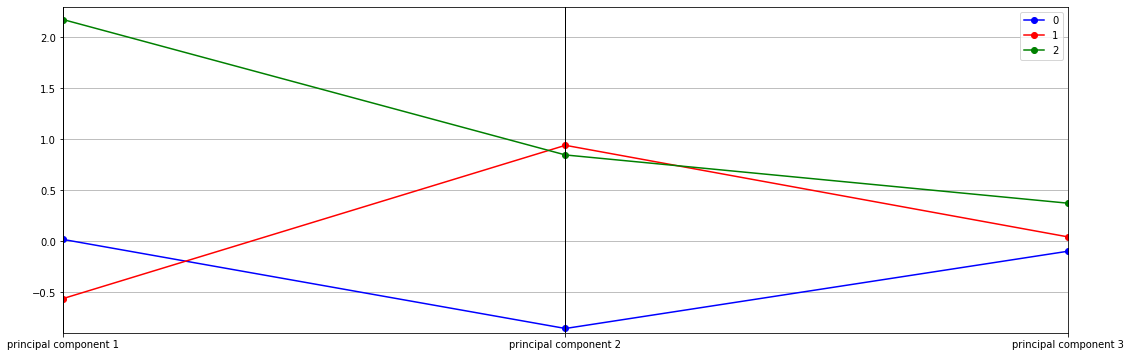

In [36]:
%matplotlib inline

# parallel plot for three class representatives of K-means on PCA result
parallel_plot(Pan_pca,[-0.9,2.3])

<IPython.core.display.Javascript object>


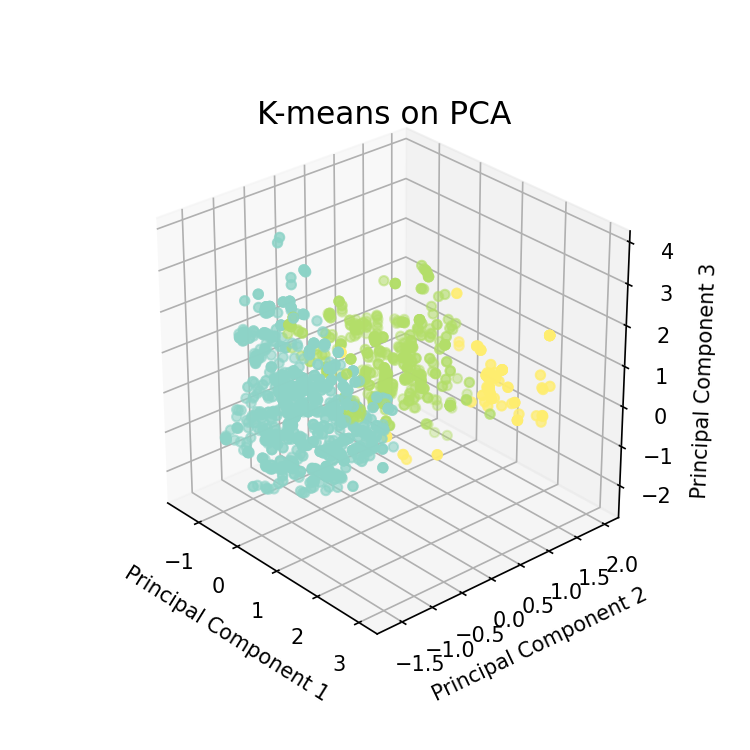

In [37]:
%matplotlib notebook

# plot out k-means results
k_means_predicted = model_kmeans_pca.predict(data_pca)

plt.figure('K-Means on 3 component analysis', figsize=(5,5))
ax_2 = plt.axes(projection = '3d')
ax_2.scatter(data_pca[:1500,0],data_pca[:1500,1],data_pca[:1500,2], c=k_means_predicted[:1500] , cmap='Set3', s=20)
ax_2.set_title('K-means on PCA', fontsize=15)
ax_2.set_xlabel('Principal Component 1', fontsize=10)
ax_2.set_ylabel('Principal Component 2', fontsize=10)
ax_2.set_zlabel('Principal Component 3', fontsize=10)
plt.show()

# SKLearn Model Prediction

## Get FIFA Data

In [38]:
def get_match_stat(match, player_data):
    """
    Get FIFA stats for a given match
    """
    match_date = match["date"]
    players = ["home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    
    total_player_stat = pd.DataFrame(columns=['match_api_id'])
    
    # store match id
    total_player_stat.loc[0] = match["match_api_id"]
    
    # store each player's features
    for player in players:
        player_id = match[player]
        player_stat = player_data[player_data["player_api_id"]==player_id]
        
        # choose most recent player stat and interested features
        player_stat = player_stat[player_stat["date"] < match_date][0:1]
        player_stat = player_stat[player_stat.columns[4:]]
        
        # rename keys
        new_keys = []
        for key in player_stat.columns:
            key_name = "{}_{}".format(player, key)
            new_keys.append(key_name)
        player_stat.columns = new_keys
        player_stat.reset_index(inplace=True, drop=True)
        
        # concate data
        total_player_stat = pd.concat([total_player_stat, player_stat], axis=1)
        
    return total_player_stat.loc[0]

        
def get_FIFA(match_data, player_data, path="", load_data=False):
    """
    Get FIFA data for all matches
    """
    if load_data:
        print("Loading FIFA data...")
        fifa_data = pd.read_pickle(path + "fifa_data.pkl")
        print("Finish")
    else:
        print("Collecting FIFA data...")
        fifa_data = match_data.apply(lambda x: get_match_stat(x, player_data), axis=1)
        print("Finish")

        #Save data as pickle
        fifa_data.to_pickle("fifa_data.pkl", protocol=2)
    return fifa_data

In [39]:
# interested match columns
cols = ["date", "match_api_id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal",
        "home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", 
        "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10", 
        "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4", 
        "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9", 
        "away_player_10", "away_player_11"]

matches = matches.dropna(subset=cols)[cols]
fifa_data = get_FIFA(matches, player_attributes, load_data=True)

Loading FIFA data...
Finish


In [40]:
fifa_data = fifa_data.dropna().select_dtypes(['number'])
fifa_data.head()

,match_api_id,home_player_1_overall_rating,home_player_1_potential,home_player_1_crossing,home_player_1_finishing,home_player_1_heading_accuracy,home_player_1_short_passing,home_player_1_volleys,home_player_1_dribbling,home_player_1_curve,...,away_player_11_vision,away_player_11_penalties,away_player_11_marking,away_player_11_standing_tackle,away_player_11_sliding_tackle,away_player_11_gk_diving,away_player_11_gk_handling,away_player_11_gk_kicking,away_player_11_gk_positioning,away_player_11_gk_reflexes
155,493027,67.0,69.0,29.0,36.0,25.0,52.0,9.0,23.0,11.0,...,67.0,56.0,40.0,35.0,37.0,1.0,23.0,62.0,23.0,23.0
162,493034,58.0,67.0,25.0,25.0,25.0,25.0,10.0,25.0,16.0,...,73.0,65.0,27.0,38.0,31.0,3.0,23.0,54.0,23.0,23.0
189,493061,67.0,69.0,29.0,36.0,25.0,52.0,9.0,23.0,11.0,...,46.0,66.0,21.0,29.0,24.0,1.0,23.0,45.0,23.0,23.0
226,493089,61.0,65.0,23.0,23.0,34.0,35.0,10.0,21.0,5.0,...,62.0,46.0,21.0,23.0,20.0,1.0,21.0,28.0,21.0,21.0
244,493107,66.0,69.0,21.0,21.0,37.0,23.0,16.0,21.0,27.0,...,75.0,88.0,20.0,35.0,28.0,1.0,20.0,55.0,20.0,20.0


## Get Label

In [41]:
def get_label_from_match(match):
    """
    Get label from a given match
    """
    label = pd.DataFrame()
    label.loc[0, "match_api_id"] = match["match_api_id"]
    home_goal = match["home_team_goal"]
    away_goal = match["away_team_goal"]

    if home_goal > away_goal:
        label.loc[0, "label"] = 0
    elif home_goal < away_goal:
        label.loc[0, "label"] = 1
    else:
        label.loc[0, "label"] = 2
    return label.loc[0]

In [42]:
labels = matches.apply(get_label_from_match, axis=1)
labels = labels[labels["match_api_id"].isin(fifa_data["match_api_id"])]

In [43]:
data = pd.merge(fifa_data, labels, on="match_api_id")
data.drop("match_api_id", axis=1, inplace=True)

## Data Preprocessing

In [44]:
# extract features and label data
labels = data.loc[:, "label"]
input_features = data.drop("label", axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(input_features, labels, test_size=0.1, shuffle=True)

## Model Testing

### without PCA

In [45]:
# Gaussian Naive Bayes
GNB_clf = GaussianNB()
GNB_clf.fit(X_train, y_train)
print("GNB Success Rate: {:.2f} %".format(GNB_clf.score(X_test, y_test) * 100))


# K-Nearest Neighbors
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(X_train, y_train)
print("KNN Success Rate: {:.2f} %".format(KNN_clf.score(X_test, y_test) * 100))

GNB Success Rate: 47.01 %
KNN Success Rate: 45.79 %


### with PCA

In [46]:
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [47]:
# Gaussian Naive Bayes
GNB_clf = GaussianNB()
GNB_clf.fit(X_train_pca, y_train)
print("GNB Success Rate: {:.2f} %".format(GNB_clf.score(X_test_pca, y_test) * 100))


# K-Nearest Neighbors
KNN_clf = KNeighborsClassifier()
KNN_clf.fit(X_train_pca, y_train)
print("KNN Success Rate: {:.2f} %".format(KNN_clf.score(X_test_pca, y_test) * 100))

GNB Success Rate: 50.33 %
KNN Success Rate: 45.85 %


# Neural Network Prediction

## define NN object

In [48]:
class Soccernet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(770, 500)
        self.fc2 = nn.Linear(500, 400)
        self.fc3 = nn.Linear(400, 200)
        self.fc4 = nn.Linear(200, 50)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(50, 3)

    def forward(self, xb):
        xb = self.relu(self.fc1(xb))
        xb = self.relu(self.fc2(xb))
        xb = self.relu(self.fc3(xb))
        xb = self.relu(self.fc4(xb))
        xb = self.fc(xb)
        return xb

In [49]:
def train(train_loader, model, criterion, optimizer, epoch, train_acc):
    losses = Average()
    precision = Average()

    model.train()

    for i, (input, target) in enumerate(train_loader):


        input=input.cuda()
        target = target.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        output = model(input_var)
        loss = criterion(output, target_var)

        prec = accuracy(output.data, target)
        losses.update(loss.data, input.size(0))
        precision.update(prec[0][0], input.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        curr_lr = optimizer.param_groups[0]['lr']
        
        if i % 50 == 0:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'LR: {4}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Precision {precision.val:.3f} ({precision.avg:.3f})'.format(
                   epoch, 50, i, len(train_loader), curr_lr,
                   loss=losses, precision=precision))

    print('Training Precision {precision.avg:.3f}'.format(precision=precision))
    train_acc.append(precision.avg.cpu().data.numpy())

def validate(val_loader, model, criterion, test_acc):
    losses = Average()
    precision = Average()

    model.eval()

    for i, (input, target) in enumerate(val_loader):
        input=input.cuda()
        target = target.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        output = model(input_var)
        loss = criterion(output, target_var)

        prec = accuracy(output.data, target)
        losses.update(loss.data, input.size(0))
        precision.update(prec[0][0], input.size(0))


    print('Testing Precsion {precision.avg:.3f}'.format(precision=precision))
    test_acc.append(precision.avg.cpu().data.numpy())

class Average(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

## data processing

In [50]:
X_train = X_train.values.astype(np.float32)
y_train = y_train.values.astype(np.int64)
X_test = X_test.values.astype(np.float32)
y_test = y_test.values.astype(np.int64)

X_train, y_train, X_test, y_test = map(torch.tensor, (X_train, y_train, X_test, y_test))

In [51]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=100, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=100)

## Trainning

In [52]:
epochs = 50
train_acc= []
test_acc= []

device = torch.device("cuda")
model = Soccernet()
if torch.cuda.is_available():
    model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(epochs):
    lr_step = [10,20,30,40,50]
    if epoch in lr_step:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
            
    train(train_dl, model, criterion, optimizer, epoch, train_acc)

    with torch.no_grad():
        validate(test_dl, model, criterion, test_acc)

Epoch: [0/50][0/163]	LR: 0.0001	Loss 1.2631 (1.2631)	Precision 21.000 (21.000)
Epoch: [0/50][50/163]	LR: 0.0001	Loss 1.0457 (1.0784)	Precision 45.000 (44.059)
Epoch: [0/50][100/163]	LR: 0.0001	Loss 1.0227 (1.0619)	Precision 52.000 (45.436)
Epoch: [0/50][150/163]	LR: 0.0001	Loss 1.0124 (1.0528)	Precision 57.000 (46.490)
Training Precision 46.615


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Testing Precsion 50.388
Epoch: [1/50][0/163]	LR: 0.0001	Loss 1.0510 (1.0510)	Precision 48.000 (48.000)
Epoch: [1/50][50/163]	LR: 0.0001	Loss 0.9897 (1.0210)	Precision 52.000 (49.863)
Epoch: [1/50][100/163]	LR: 0.0001	Loss 1.0269 (1.0237)	Precision 54.000 (49.594)
Epoch: [1/50][150/163]	LR: 0.0001	Loss 1.0810 (1.0211)	Precision 38.000 (49.815)
Training Precision 49.729
Testing Precsion 50.554
Epoch: [2/50][0/163]	LR: 0.0001	Loss 1.0233 (1.0233)	Precision 51.000 (51.000)
Epoch: [2/50][50/163]	LR: 0.0001	Loss 0.9822 (1.0125)	Precision 54.000 (50.725)
Epoch: [2/50][100/163]	LR: 0.0001	Loss 0.9892 (1.0087)	Precision 59.000 (51.307)
Epoch: [2/50][150/163]	LR: 0.0001	Loss 0.9498 (1.0093)	Precision 57.000 (51.185)
Training Precision 51.231
Testing Precsion 51.163
Epoch: [3/50][0/163]	LR: 0.0001	Loss 0.9855 (0.9855)	Precision 47.000 (47.000)
Epoch: [3/50][50/163]	LR: 0.0001	Loss 1.0197 (1.0138)	Precision 49.000 (49.902)
Epoch: [3/50][100/163]	LR: 0.0001	Loss 1.0121 (1.0111)	Precision 48.000 (50

Epoch: [22/50][150/163]	LR: 1.0000000000000002e-06	Loss 0.9422 (0.9834)	Precision 58.000 (52.523)
Training Precision 52.505
Testing Precsion 51.495
Epoch: [23/50][0/163]	LR: 1.0000000000000002e-06	Loss 0.9967 (0.9967)	Precision 52.000 (52.000)
Epoch: [23/50][50/163]	LR: 1.0000000000000002e-06	Loss 1.0506 (0.9837)	Precision 42.000 (52.686)
Epoch: [23/50][100/163]	LR: 1.0000000000000002e-06	Loss 1.0262 (0.9858)	Precision 52.000 (52.277)
Epoch: [23/50][150/163]	LR: 1.0000000000000002e-06	Loss 1.0419 (0.9849)	Precision 46.000 (52.199)
Training Precision 52.413
Testing Precsion 51.495
Epoch: [24/50][0/163]	LR: 1.0000000000000002e-06	Loss 1.0177 (1.0177)	Precision 50.000 (50.000)
Epoch: [24/50][50/163]	LR: 1.0000000000000002e-06	Loss 0.9142 (0.9853)	Precision 56.000 (52.255)
Epoch: [24/50][100/163]	LR: 1.0000000000000002e-06	Loss 1.0219 (0.9858)	Precision 47.000 (52.119)
Epoch: [24/50][150/163]	LR: 1.0000000000000002e-06	Loss 0.9859 (0.9833)	Precision 51.000 (52.510)
Training Precision 52.48

Epoch: [41/50][150/163]	LR: 1.0000000000000004e-08	Loss 0.9357 (0.9834)	Precision 58.000 (52.437)
Training Precision 52.468
Testing Precsion 51.550
Epoch: [42/50][0/163]	LR: 1.0000000000000004e-08	Loss 0.9954 (0.9954)	Precision 52.000 (52.000)
Epoch: [42/50][50/163]	LR: 1.0000000000000004e-08	Loss 0.9214 (0.9831)	Precision 58.000 (52.216)
Epoch: [42/50][100/163]	LR: 1.0000000000000004e-08	Loss 1.0277 (0.9847)	Precision 48.000 (52.327)
Epoch: [42/50][150/163]	LR: 1.0000000000000004e-08	Loss 0.8984 (0.9857)	Precision 60.000 (52.205)
Training Precision 52.474
Testing Precsion 51.550
Epoch: [43/50][0/163]	LR: 1.0000000000000004e-08	Loss 1.0001 (1.0001)	Precision 50.000 (50.000)
Epoch: [43/50][50/163]	LR: 1.0000000000000004e-08	Loss 0.9930 (0.9880)	Precision 53.000 (52.235)
Epoch: [43/50][100/163]	LR: 1.0000000000000004e-08	Loss 1.0426 (0.9813)	Precision 43.000 (52.574)
Epoch: [43/50][150/163]	LR: 1.0000000000000004e-08	Loss 0.9793 (0.9837)	Precision 53.000 (52.437)
Training Precision 52.46

## Plots

<IPython.core.display.Javascript object>


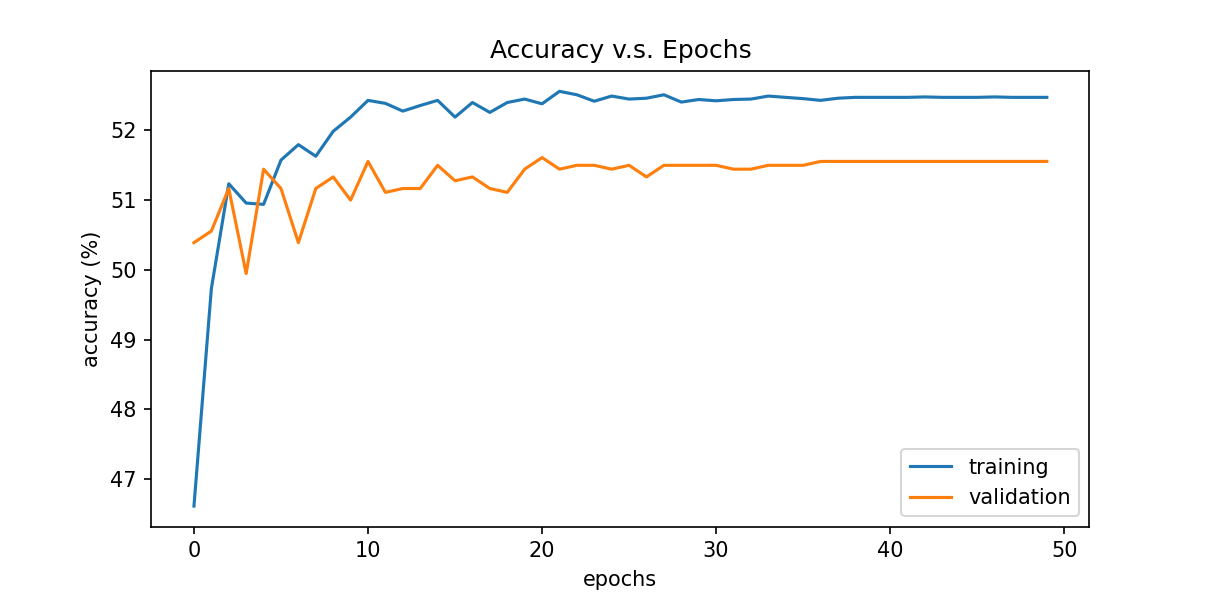

Text(0, 0.5, 'accuracy (%)')

In [54]:
plt.figure(figsize=(8,3))
plt.plot(train_acc)
plt.plot(test_acc)
plt.legend(("training", "validation"))
plt.title("Accuracy v.s. Epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")